In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import ray
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from src.acnets.pipeline import MultiScaleClassifier, Parcellation


In [2]:
N_RUNS = 100      # 10 independent train/test runs
TEST_SIZE = .25  # proportion of test subjects out of 32 subjects

In [3]:
# Xy
subjects = Parcellation(atlas_name='difumo_64_2mm').fit_transform(None).coords['subject'].values
X = subjects.reshape(-1,1)                                  # subjects ids, shape: (n_subjects, 1)

y_encoder = LabelEncoder()
y = y_encoder.fit_transform([s[:4] for s in subjects])      # labels (AVGP=1 or NVGP=1), shape: (n_subjects,)
y_mapping = dict(zip(y_encoder.classes_, y_encoder.transform(y_encoder.classes_)))

# DEBUG (report label mapping)
print('[DEBUG] label mapping:', y_mapping)

# DEBUG (expected to overfit, i.e., accuracy is 1)
overfit_score = MultiScaleClassifier().fit(X, y).score(X, y)
print(f'[DEBUG] overfit accuracy: {overfit_score:.3f}')

[DEBUG] label mapping: {'AVGP': 0, 'NVGP': 1}
[DEBUG] overfit accuracy: 1.000


In [4]:
xgb_param_space = {
    # 'atlas': ['dosenbach2010', 'gordon2014_2mm', 'difumo_64_2mm'],
    'atlas': tune.choice(['dosenbach2010']),
    'extract_h1_features': tune.grid_search([False]),
    'extract_h2_features': tune.grid_search([True, False]),
    'extract_h3_features': tune.grid_search([True]),
    # 'clf__subsample': tune.choice([.5, .8, 1]),
    'clf__n_estimators': tune.grid_search([100, 200]),
    'clf__max_depth': tune.grid_search([2, 4, 6, 8]),
    'clf__learning_rate': tune.grid_search([.1, .3]),
    # 'clf__colsample_bytree': tune.uniform(0.1, 1.0),
    # 'clf__colsample_bylevel': tune.uniform(0.1, 1.0),
    # TODO 'clf__bagging_fraction': tune.uniform(0.01, 1.0),
    # TODO 'clf__min_child_weight': tune.randint(1, 10),
}

rfc_param_space = {
    # 'clf': RandomForestClassifier(),
    # 'atlas': tune.choice(['dosenbach2010', 'gordon2014_2mm', 'difumo_64_2mm']),
    'atlas': tune.choice(['dosenbach2010']),
    'clf__n_estimators': tune.randint(100, 500),
    'clf__max_depth': tune.randint(1, 8),
    'clf__min_samples_split': tune.randint(2, 8),
    'clf__min_samples_leaf': tune.randint(1, 5),
    'clf__criterion': tune.choice(['gini', 'entropy']),
    'clf__max_features': tune.choice([None, 'sqrt'])
}

svm_param_space = {
    # 'clf': LinearSVC(max_iter=100000),
    # 'atlas': tune.choice(['dosenbach2010', 'gordon2014_2mm', 'difumo_64_2mm']),
    'atlas': tune.choice(['dosenbach2010']),
    'clf__penalty': ['l1'],
    'clf__dual': [False],
    'clf__C': tune.choice([.01, .1, 1, 10, 100, 1000]),
    # 'clf__kernel': ['linear','poly','rbf','sigmoid'],
    # 'clf__gamma': tune.choice(['scale'])
}

from sklearn.model_selection import train_test_split
from IPython.display import display

def eval_model(config,
               X=X, y=y,
               n_runs=10,
               classifier=XGBClassifier(base_score=.5, objective='binary:logistic')):

    val_scores = []
    test_scores = []

    model = MultiScaleClassifier(classifier=classifier).set_params(**config)

    for i in range(n_runs):

        # outer CV
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y)
        # outer_cv = StratifiedShuffleSplit(n_splits=3, test_size=TEST_SIZE)

        # Inner CV
        inner_cv = StratifiedShuffleSplit(n_splits=5, test_size=TEST_SIZE)

        # fit and score
        val_score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=inner_cv).mean()

        # test score (we only report this and do not use it during HPO)
        test_score = model.fit(X_train, y_train).score(X_test, y_test)

        val_scores.append(val_score)
        test_scores.append(test_score)

    return {'val_accuracy': np.mean(val_scores), 'test_accuracy': np.mean(test_scores)}

# DEBUG
config = dict(atlas='dosenbach2010', extract_h1_features=False, extract_h2_features=True)

# model = MultiScaleClassifier().set_params(**config)
# model.fit(X, y)
eval_model(config, n_runs=1)

{'val_accuracy': 0.5, 'test_accuracy': 0.75}

In [5]:

#############################################
# HPO
#############################################

param_space = xgb_param_space

ray.shutdown(); ray.init()

tuner = tune.Tuner(
    eval_model,
    param_space=param_space,
    tune_config=tune.TuneConfig(
        num_samples=1,
    )
)

tuning_results = tuner.fit()
ray.shutdown()


# clear_output()
print('[DEBUG] Best HPO score:',
      tuner.get_results().get_best_result(metric='val_accuracy', mode='max').metrics['val_accuracy'])

# create a tuned model using the best hyper-parameters
best_params = tuner.get_results().get_best_result(metric='val_accuracy', mode='max').config
tuned_model = MultiScaleClassifier(classifier=XGBClassifier()).set_params(**best_params)
tuned_model

2023-10-02 13:55:36,041	INFO tune.py:1143 -- Total run time: 167.85 seconds (167.80 seconds for the tuning loop).


[DEBUG] Best HPO score: 0.7849999999999999


MultiScaleClassifier()

In [6]:
cv_scores = cross_val_score(tuned_model, X, y,
                            cv=StratifiedShuffleSplit(n_splits=N_RUNS, test_size=TEST_SIZE),
                            verbose=3, n_jobs=-1)

# calculate 95% confidence interval
bootstrap_ci = stats.bootstrap(cv_scores.reshape(1,-1), np.mean)

clear_output(wait=True)
print(f'Test accuracy (mean ± std): {cv_scores.mean():.2f} ± {cv_scores.std():.2f}')
print(bootstrap_ci.confidence_interval)

Test accuracy (mean ± std): 0.73 ± 0.12
ConfidenceInterval(low=0.71, high=0.7575)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished
/home/morteza/micromamba/envs/acnets/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/morteza/micromamba/envs/acnets/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


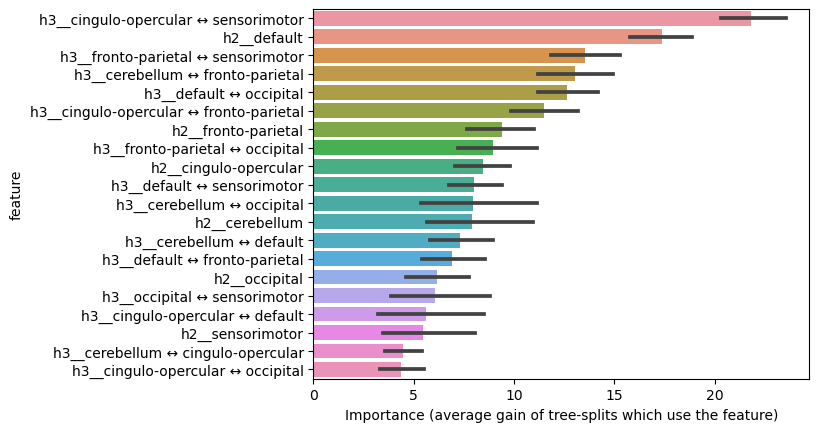

In [7]:
# Permutation Feature Importance

def get_importance(estimator, X_train, y_train, X_test, y_test, scoring='accuracy'):
    """Perform permutation importance analysis on a given estimator."""
    estimator.fit(X_train, y_train)
    feature_names = estimator.get_feature_extractor().get_feature_names_out()
    selected_feature_names = estimator[2:-1].get_feature_names_out(feature_names)

    if 'xgb' in estimator.named_steps['clf'].__class__.__name__.lower():
        # for xgb classifier we use its booster's get_score() method
        booster = estimator.named_steps['clf'].get_booster()
        booster.feature_names = selected_feature_names.tolist()
        importance = booster.get_score(importance_type='weight', fmap='')
    elif 'feature_importances_' in dir(estimator.named_steps['clf']):
        # for some other classifiers we use their feature_importances_ attribute
        importance = estimator.named_steps['clf'].feature_importances_
    else:
        # generic permutation importance
        X_test_features = estimator.get_feature_extractor().transform(X_test)
        feature_names = estimator.get_feature_extractor().get_feature_names_out()
        importance = permutation_importance(estimator.get_classification_head(),
                                         X_test_features,
                                         y_test,
                                         n_jobs=-1,
                                         scoring=scoring)['importances_mean']
        importance = dict(zip(feature_names, importance))

    importance_df = pd.DataFrame([(k, v)
                                  for k, v in importance.items()],
                                 columns=['feature', 'importance'])
    return importance_df


# run permutation importance in parallel
importances = Parallel(n_jobs=-1, verbose=2)(
    delayed(get_importance)(
        estimator = tuned_model,
        X_train = X[train],
        y_train = y[train],
        X_test = X[test],
        y_test = y[test])
    for train, test in StratifiedShuffleSplit(n_splits=N_RUNS, test_size=TEST_SIZE).split(X, y)
)

# # convert importance scores to dataframe and sort

importance_scores = pd.concat(importances, axis=0)

# sort features by importance and select top-20 
order = importance_scores.groupby('feature').mean().sort_values('importance', ascending=False)[:20].index

# TODO plot H1, H2, H3 features importances

sns.barplot(data=importance_scores,
            order=order,  
            x='importance',
            y='feature',
            errorbar=('ci', 95),
            orient='h')

plt.xlabel('Importance (average gain of tree-splits which use the feature)')
plt.show()
